Epoch 1, Loss: 1.810
Epoch 2, Loss: 1.521
Epoch 3, Loss: 1.429
Epoch 4, Loss: 1.351
Epoch 5, Loss: 1.286
Test Accuracy: 53.42%


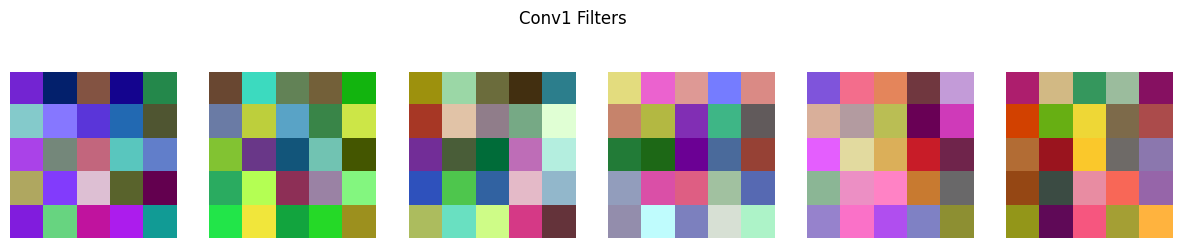

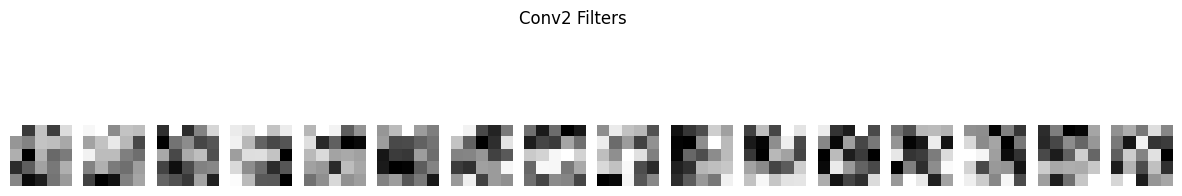

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# 2. Define CNN from scratch
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # 3 input channels, 6 filters
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels, 16 filters
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Train the network
for epoch in range(5):
    running_loss = 0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}")

# 5. Evaluate performance
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 6. Visualize learned filters from conv1 and conv2
def visualize_filters(conv_layer, num_filters, title):
    filters = conv_layer.weight.data.cpu()
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 3))
    for i in range(num_filters):
        f = filters[i]
        # If filter has 3 channels (like conv1), show as RGB
        if f.shape[0] == 3:
            f = (f - f.min()) / (f.max() - f.min())
            f = f.permute(1, 2, 0)  # C,H,W -> H,W,C
            axes[i].imshow(f)
        else:
            # For multi-channel filters (like conv2), show first channel in grayscale
            f = f[0]  # take first channel only
            f = (f - f.min()) / (f.max() - f.min())
            axes[i].imshow(f, cmap="gray")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

visualize_filters(model.conv1, 6, "Conv1 Filters")
visualize_filters(model.conv2, 16, "Conv2 Filters")
